# Deep Learning Pneumonia Detection

**Authors:** Meir Alelov, Greg Burgess

![UNICEF pneumonia mortality rates](images/UNICEF_mortality_percentages.png)

## Overview

We have built a convolutional neural network model which accurately classifies pediatric chest X-ray images as having pneumonia or not. This model was trained on pediatric chest X-ray images and, through an iterative modeling approach, has achieved an overall accuracy of 89.1%, recall of 95.6%, and precision of 87.9%. This could be an important tool to reduce childhood mortality, especially in impoverished regions with less access to advanced healthcare systems.

## Business Problem

Worldwide, over 800,000 children under five die every year from pneumonia. Pediatric mortality rates are especially high in regions affected by poverty and inadequate access to health care.  [source](https://data.unicef.org/topic/child-health/pneumonia/)

Low-resource settings are less likely to have access to rapid radiological interpretation of images, which could result in a delay of clinical care and poorer prognosis [source](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

We set out to determine whether we could use deep learning to quickly and accurately classify pneumonia in x-ray images. Information from a fast, automated deep learning classifier could assist clinicians in low-resource settings to make pneumonia diagnoses more quickly. Expediting diagnoses in these situations may result in a substantial reduction in childhood mortality from pneumonia.

## Data Understanding

Data for this investigation were originally acquired by [Kermany et al. (2018)](https://doi.org/10.1016/j.cell.2018.02.010). 

These chest X-ray images were acquired at Guangzhou Women and Children’s Medical Center in Guangzhou, China as part of routine clinical care. Patients were aged between one and five years old. Our training set included 3875 pneumonia images and 1341 normal images, and the held out test set included 390 pneumonia images and 234 normal images.

Pneumonia is indicated by abnormal opacification in the x-ray image, compared to clearly visible vascular features in normal x-rays.

Kermany et al. provided public access to their data in [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2). We are using an organized subset of their data, which was downloaded from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).



Directory structure
```
├── chest-xray                    
│   ├── test                      <- Test set images
│   │   ├── Normal                     <- Normal lung photos        (234 images)
│   │   │   └── ...
│   │   └── Pneumonia                  <- Pneumonia lung photos     (390 images)
│   │   │   └── ...
│   ├── train                     <- Training set images
│   │   ├── Normal                     <- Normal lung photos        (1341 images)
│   │   │   └── ...
│   │   └── Pneumonia                  <- Pneumonia lung photos     (3875 images)
│   │   │   └── ...
│   ├── val                       <- Training set images
│   │   ├── Normal                     <- Normal lung photos        (8 images)
│   │   │   └── ...
│   │   └── Pneumonia                  <- Pneumonia lung photos     (8 images)
│   │   │   └── ...
```

In [3]:
# Import Relevant Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image

# scikit-learn
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay, plot_roc_curve, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# Neural network libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, metrics, regularizers, losses
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.layers import Dense, Dropout, Flatten

np.random.seed(42)
%matplotlib inline

## Data Preparation

We can set up paths to run these models in different environments. Below is an example mounting a Google Drive in Google Colab.

In [4]:
# Running on local machine
root_path = './'

# # Running in Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive')
# root_path = 'gdrive/My Drive/Colab Notebooks/Pneumonia/'

First, we downloaded the zipped data file from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) and unzipped it inside of the `data/` directory.

We chose not to use the images in the `val` directory, because that data only had 8 normal and 8 pneumonia images. Because of that, we chose to create our own validation set with a larger number of images.

In [5]:
train_path = root_path + 'data/chest_xray/train/'
test_path = root_path + 'data/chest_xray/test/'

The ImageDataGenerator class can generate batches of vectorized image data that is suitable for input into keras models. Importantly, the ImageDataGenerator can use the directory structure to determine the target category labels (normal vs. pneumonia) for use during training and evaluation of the models.

Because we chose not to use the images in the `val` directory as our validation set, we created a new validation set using the `validation_split` option.

In [6]:
# Instantiate ImageDataGenerator, and create 'validation' subset containing 20% of data
idg = ImageDataGenerator(rescale=1/255, validation_split=0.20)

# train_set comes from `train_path`, but contains only training subset (first 80% of images)
train_set = idg.flow_from_directory(train_path, 
                                    target_size=(128, 128), 
                                    color_mode='grayscale', 
                                    class_mode='binary', 
                                    subset='training')

# validation_set comes from `train_path`, but contains only validation subset (last 20% of images)
validation_set = idg.flow_from_directory(train_path, 
                                         target_size=(128, 128), 
                                         color_mode='grayscale', 
                                         class_mode='binary', 
                                         subset='validation')

# test_set comes from `test_path`, and contains images that were completely unseen by model during training
test_set = idg.flow_from_directory(test_path, 
                                   target_size=(128,128), 
                                   color_mode='grayscale', 
                                   class_mode='binary', 
                                   shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Example input images

Above, we downsampled images by setting `target_size` to a uniform size of 128x128 pixels. This reduced the size of the image data going into the models, making them less computationally expensive. We expect that this resolution will nonetheless maintain enough image detail for the model to utilize during training.

Let's look at some example images after this rescaling.

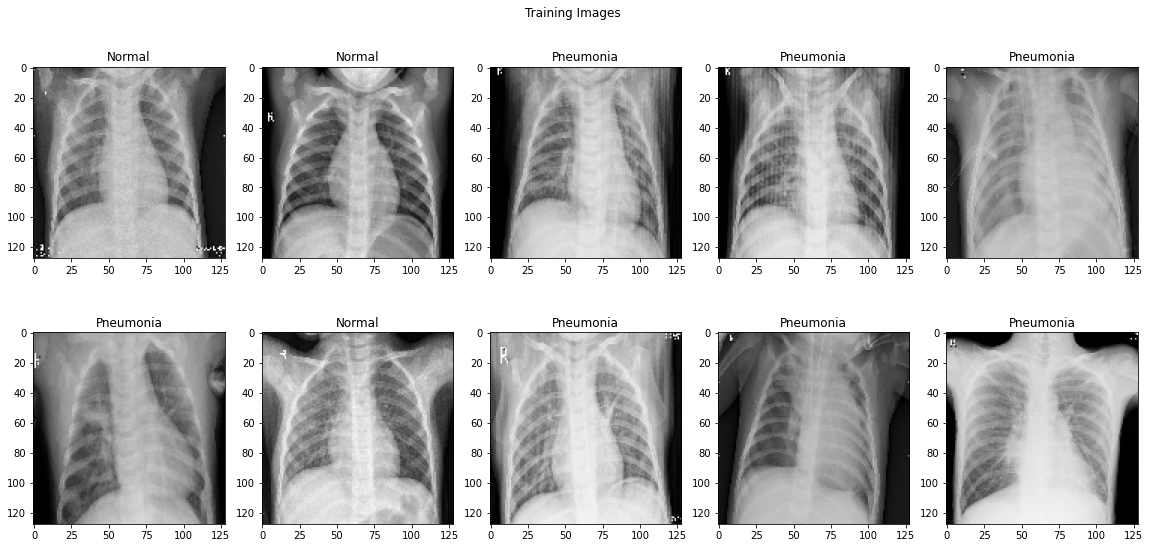

In [5]:
class_dict = {0:'Normal', 1:'Pneumonia'}
train_images = train_set.next()


# Visualize
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

for i in range(10):
    # Load image into numpy array and re-scale (back to 0 through 255)
    img = np.array(train_images[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5] # make a 2x5 grid, and step through it
    ax.set_title(class_dict[train_images[1][i]])
    ax.imshow(img, cmap ='gray')
fig.suptitle('Training Images')
plt.tight_layout()
#plt.savefig('../images/training_images_orig.jpg', transparent = False, bbox_inches="tight")

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### DummyClassifier

In [6]:
# Get information about image size and number of images
# to be used in running DummyClassifier() below

train_target_size = train_set.image_shape[0:2] # image dimensions (128x128)
train_batch_size  = train_set.n                # number of images in train set

test_target_size  = test_set.image_shape[0:2]  # image dimensions (128x128)
test_batch_size   = test_set.n                 # number of images in test set

In [7]:
# Batch size set to the total number of images found above, so that dummy model gets full data set. 
# Validation set not needed for dummy model
train_set_dummy = idg.flow_from_directory(train_path,
                                          target_size=train_target_size,
                                          color_mode='grayscale', 
                                          class_mode='binary', 
                                          subset='training', 
                                          batch_size=train_batch_size)

test_set_dummy  = idg.flow_from_directory(test_path, 
                                          target_size=test_target_size,
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          shuffle=False,
                                          batch_size=test_batch_size)

Found 4173 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# Split train and test dummy sets into 
# images and corresponding labels for dummy model training
train_images, train_labels = next(train_set_dummy)
test_images, test_labels = next(test_set_dummy)

In [9]:
baseline_model = DummyClassifier(strategy= 'most_frequent')
baseline_model.fit(train_images, train_labels)

DummyClassifier(strategy='most_frequent')

Baseline accuracy: 0.625
Baseline recall: 1.0
Baseline recall: 0.625


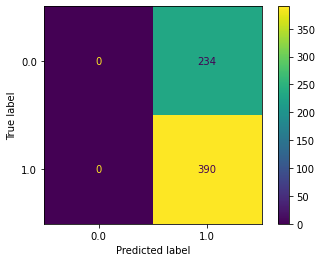

In [10]:
# Get predicted values from dummy model (always predict "most_frequent" class)
y_base_pred = baseline_model.predict(test_images)

base_acc = baseline_model.score(test_images, test_labels)
base_recall = recall_score(test_labels, y_base_pred)
base_precision = precision_score(test_labels, y_base_pred)

print(f"Baseline accuracy: {base_acc}")
print(f"Baseline recall: {base_recall}")
print(f"Baseline recall: {base_precision}")


plot_confusion_matrix(baseline_model, test_images, test_labels);

### Create helper functions

We created this function to plot training performance for our neural network models

In [7]:
def model_metrics(results):
    
#    results = model.history
    
    train_loss = results.history['loss']
    train_acc = results.history['accuracy']
    train_recall = results.history['recall']
    train_precision = results.history['precision']
    
    val_loss = results.history['val_loss']
    val_acc = results.history['val_accuracy']
    val_recall = results.history['val_recall']
    val_precision = results.history['val_precision']
    
    print(f"AUC score (train final epoch): {results.history['auc'][-1]:.3f}")
    print(f"AUC score (val final epoch)  : {results.history['val_auc'][-1]:.3f}")

    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()


    sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
    sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    
    sns.lineplot(x=results.epoch, y=train_recall, ax=ax3, label='train_recall')
    sns.lineplot(x=results.epoch, y=val_recall, ax=ax3, label='val_recall')
    ax3.set_title('Recall')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Recall')
    ax3.legend()


    sns.lineplot(x=results.epoch, y=train_precision, ax=ax4, label='train_precision')
    sns.lineplot(x=results.epoch, y=val_precision, ax=ax4, label='val_precision')
    ax4.set_title('Precision')    
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend()

If we save previously run models to disk, and read them back in later, the training history isn't saved in the keras model. Therefore, we save the history separately and read it back into a pd.DataFrame. We need a way to plot performance from these retrieved data frames.

In [17]:
def model_metrics_from_dataframe(df):
    
    print(f"AUC score (train final epoch): {df['auc'].iloc[-1]:.3f}")
    print(f"AUC score (val final epoch)  : {df['val_auc'].iloc[-1]:.3f}")

    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

    sns.lineplot(x=df.index, y=df['loss'], ax=ax1, label='train_loss')
    sns.lineplot(x=df.index, y=df['val_loss'], ax=ax1, label='val_loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()


    sns.lineplot(x=df.index, y=df['accuracy'], ax=ax2, label='train_accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], ax=ax2, label='val_accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    
    sns.lineplot(x=df.index, y=df['recall'], ax=ax3, label='train_recall')
    sns.lineplot(x=df.index, y=df['val_recall'], ax=ax3, label='val_recall')
    ax3.set_title('Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Recall')
    ax3.legend()


    sns.lineplot(x=df.index, y=df['precision'], ax=ax4, label='train_precision')
    sns.lineplot(x=df.index, y=df['val_precision'], ax=ax4, label='val_precision')
    ax4.set_title('Precision')    
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Precision')
    ax4.legend()

In [8]:
def conf_and_rocauc(model):
    
    #confusion matrix
    
    y_pred = model.predict(test_set)
    y_hat = (y_pred > 0.5)           
    display(ConfusionMatrixDisplay(
        confusion_matrix(test_set.classes, y_hat), 
        display_labels=['Normal', 'Pneumonia']).plot());
    
    
    #ROC_AUC
    
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_set.classes, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)
    
    plt.figure()
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show();

### First simple model

Here we created our model

In [12]:
fsm = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

fsm.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 
             'TruePositives', 'TrueNegatives',
             'FalsePositives', 'FalseNegatives', 
             'AUC']
)

fsm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                524320    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 524,353
Trainable params: 524,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
fsm_results = fsm.fit(train_set,
                      epochs=20,
                      batch_size=None, 
                      verbose=1, 
                      validation_data=validation_set)

Epoch 1/20
131/131 [==============================] - 75s 571ms/step - loss: 0.5062 - accuracy: 0.7553 - recall: 0.9894 - precision: 0.7564 - true_positives: 3067.0000 - true_negatives: 85.0000 - false_positives: 988.0000 - false_negatives: 33.0000 - auc: 0.7851 - val_loss: 0.4265 - val_accuracy: 0.8188 - val_recall: 0.9948 - val_precision: 0.8065 - val_true_positives: 771.0000 - val_true_negatives: 83.0000 - val_false_positives: 185.0000 - val_false_negatives: 4.0000 - val_auc: 0.9355
Epoch 2/20
131/131 [==============================] - 74s 562ms/step - loss: 0.3714 - accuracy: 0.8567 - recall: 0.9894 - precision: 0.8444 - true_positives: 3067.0000 - true_negatives: 508.0000 - false_positives: 565.0000 - false_negatives: 33.0000 - auc: 0.9459 - val_loss: 0.3476 - val_accuracy: 0.8821 - val_recall: 0.9716 - val_precision: 0.8817 - val_true_positives: 753.0000 - val_true_negatives: 167.0000 - val_false_positives: 101.0000 - val_false_negatives: 22.0000 - val_auc: 0.9431
Epoch 3/20
131/

Epoch 18/20
131/131 [==============================] - 66s 505ms/step - loss: 0.1292 - accuracy: 0.9518 - recall: 0.9710 - precision: 0.9644 - true_positives: 3010.0000 - true_negatives: 962.0000 - false_positives: 111.0000 - false_negatives: 90.0000 - auc: 0.9878 - val_loss: 0.1631 - val_accuracy: 0.9291 - val_recall: 0.9381 - val_precision: 0.9655 - val_true_positives: 727.0000 - val_true_negatives: 242.0000 - val_false_positives: 26.0000 - val_false_negatives: 48.0000 - val_auc: 0.9822
Epoch 19/20
131/131 [==============================] - 61s 466ms/step - loss: 0.1265 - accuracy: 0.9535 - recall: 0.9713 - precision: 0.9663 - true_positives: 3011.0000 - true_negatives: 968.0000 - false_positives: 105.0000 - false_negatives: 89.0000 - auc: 0.9887 - val_loss: 0.1554 - val_accuracy: 0.9358 - val_recall: 0.9523 - val_precision: 0.9609 - val_true_positives: 738.0000 - val_true_negatives: 238.0000 - val_false_positives: 30.0000 - val_false_negatives: 37.0000 - val_auc: 0.9828
Epoch 20/20


Below, we've included code to save the model (after fitting) to a .h5 file using the keras model.save() method, and the training history to a .csv file using pandas. This way, previously trained models can be read in rather than re-training, which can take a while!

In [130]:
# output_path = root_path + 'data/fsm.h5'
# fsm.save(output_path)

# # Appears that you also need to save history separately
# # convert results.history to csv and save it out
# hist_df = pd.DataFrame(fsm_results.history)
# hist_df.to_csv(output_path.replace(".h5", ".csv"), index=False)

AUC score (train final epoch): 0.989
AUC score (val final epoch)  : 0.984


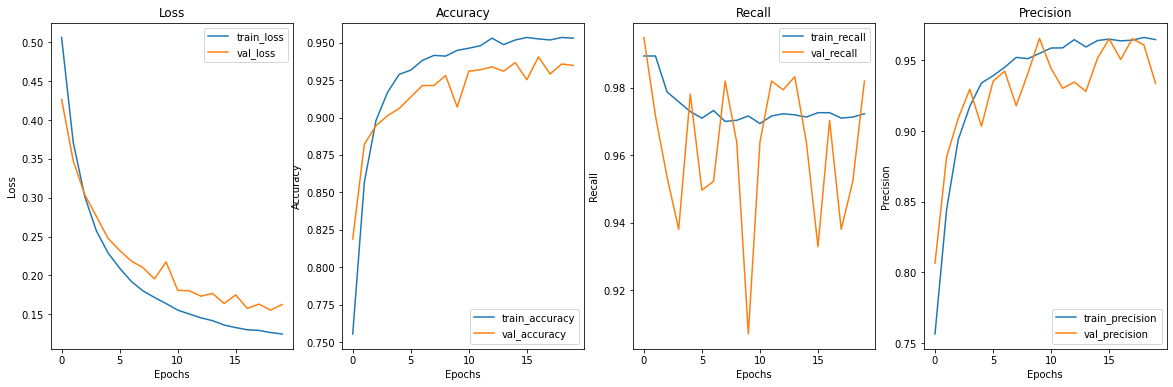

In [23]:
model_metrics(fsm_results)

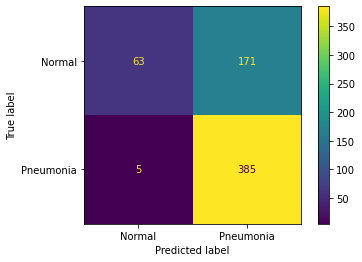

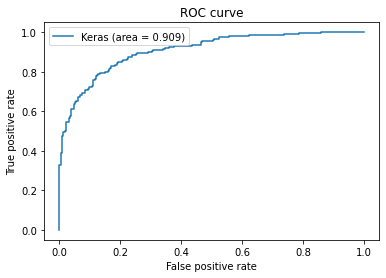

In [58]:
conf_and_rocauc(fsm)

#### Wow!!!

Train and validation scores are both very high, suggesting that we may already have a highly accurate model! 

Before we choose to proceed with this model, we need to evaluate against the unseen test set.

We expect similarly high scores in the unseen test set as well!

In [15]:
fsm.evaluate(test_set)

20/20 [==============================] - 4s 210ms/step - loss: 0.7799 - accuracy: 0.7179 - recall: 0.9872 - precision: 0.6924 - true_positives: 385.0000 - true_negatives: 63.0000 - false_positives: 171.0000 - false_negatives: 5.0000 - auc: 0.9066


[0.7799389362335205,
 0.7179487347602844,
 0.9871794581413269,
 0.6924460530281067,
 385.0,
 63.0,
 171.0,
 5.0,
 0.9065855741500854]

#### Oh no!

Unfortunately, model performance suffered on the unseen data. Our accuracy and precision are far worse on the test set than the validation set, even though *both* of those data sets were unseen during training!

This is a confusing situation. This discrepancy between performance on the test and validations set could indicate one of two things:
1. Perhaps the validation split was "lucky". Maybe, simply by chance, the ImageDataGenerator chose a split of validation images that were unusually accurate during the model evaluation.
    - To check whether this might be true, we will use different validation sets by creating a cross-validation function. 
    - That function will use the withhold different segments of the training data as validation sets, to see whether the original validation set was just lucky by comparison.
    - If we get similar performance on different validation splits, it suggests that we're not getting this performance by chance.

2. Perhaps the images in the test set were more dissimilar from the train set than the validation images were. 
    - Stated differently, if images in the `test` directory were different (came from different x-ray machines or children of different ages) than images in the `train` directory, they would be less similar to the training data than our validation images were.
    - To evaluate this possibility, we used the image manipulation functions within ImageDataGenerator to augment the training set with degraded copies of the original data. This will make the training data more variable, so as to make training harder, resulting in a more "fit" model.


### Cross-validation

We used the KerasClassifier class to wrap our model into a container that can be used by scikit-learn's cross_val_score() method.

In [30]:
# we might need this to be in a function to wrap it for our custom crossval
def build_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(128, 128, 1)),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='SGD',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 
                            'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])
    return model

In [31]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=20,
                                          verbose=3)

Before passing the keras_model into the cross_val_score() method, we need to set up training images and labels in a form that cross_val_score can use. We created a new ImageDataGenerator that made one large batch containing all of the training data. But then we use next() to separate the batch into a np.ndarray that can be used by cross_vall_score to make our k-folds.

In [51]:
idg_cv_comp = ImageDataGenerator(rescale=1/255)

train_set_cv_comp = idg_cv_comp.flow_from_directory(train_path, target_size=(128, 128),
                                    color_mode='grayscale', 
                                    class_mode='binary',
                                    batch_size=5216,
                                    subset='training')

Found 5216 images belonging to 2 classes.


In [32]:
train_images, train_labels = next(train_set_cv_comp)
print(len(train_images), len(train_labels))

5216 5216


In [33]:
cv_scores = cross_val_score(keras_model, train_images, train_labels, cv=5, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] .................................... , score=0.959, total=  14.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] .................................... , score=0.942, total=  13.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.6s remaining:    0.0s


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] .................................... , score=0.954, total=  12.9s
[CV]  ................................................................
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] .................................... , score=0.940, total=  10.3s
[CV]  ................................................................
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] ..................

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [50]:
print(cv_scores)
print(np.mean(cv_scores))

[0.95881224 0.94247365 0.9539789  0.93959731 0.94726747]
0.9484259128570557


In [46]:
fsm_results.history['val_accuracy'][-1]

0.9348034262657166

### Data Augmentation

We used ImageDataGenerator to augment our training data set, by manipulating the original training images to provide additional training images after various manipulation techniques (shear, zoom, shift, etc.). This was done in an attempt to make additional training data of varying quality so that the model would generalize to unseen data better.

In [47]:
train_idg = ImageDataGenerator(rescale=1/255,
                               validation_split = 0.20,
                               rotation_range=40, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
                                   

train_set_aug = train_idg.flow_from_directory(train_path, target_size=(128, 128), 
                                         color_mode='grayscale', class_mode='binary', subset='training')

validation_set_aug = train_idg.flow_from_directory(train_path, target_size=(128, 128), 
                                         color_mode='grayscale', class_mode='binary', subset='validation')

# We don't augment the data in the test set, so we can use the same test_set variable from above

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


Let's look at examples of the manipulated images.

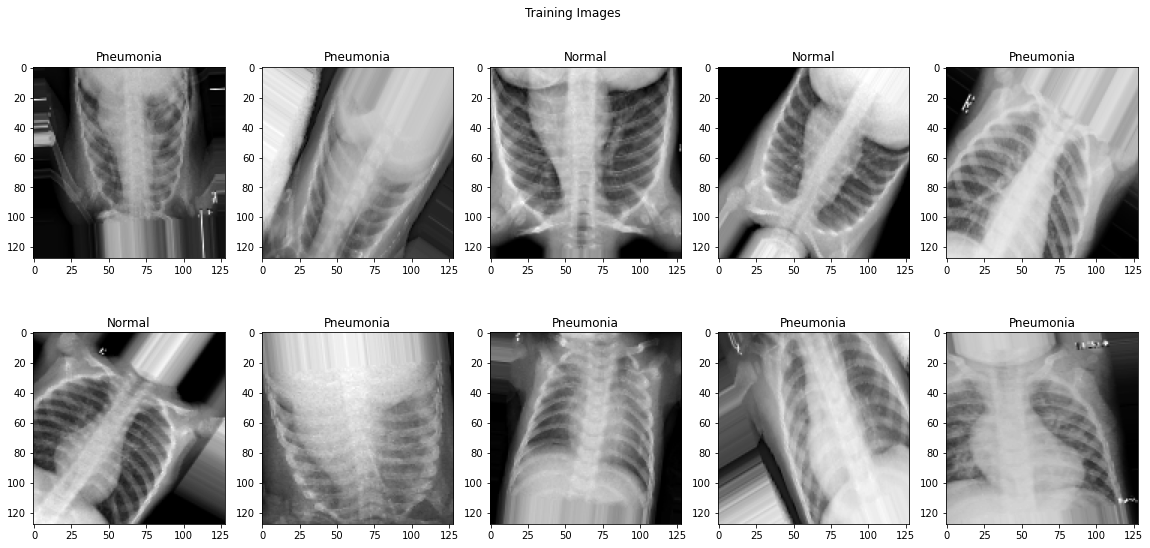

In [52]:
class_dict = {0:'Normal', 1:'Pneumonia'}
train_images_aug = train_set_aug.next()


# Visualize
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

for i in range(10):
    # Load image into numpy array and re-scale (back to 0 through 255)
    img = np.array(train_images_aug[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5] # make a 2x5 grid, and step through it
    ax.set_title(class_dict[train_images_aug[1][i]])
    ax.imshow(img, cmap ='gray')
fig.suptitle('Training Images')
plt.tight_layout()

### First simple model with augmented data

In [48]:
fsm_aug = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

fsm_aug.compile(optimizer='SGD',
                loss='binary_crossentropy',
                metrics=['accuracy', 'Recall', 'Precision', 
                         'TruePositives', 'TrueNegatives', 
                         'FalsePositives', 'FalseNegatives', 
                         'AUC']
               )

In [49]:
fsm_aug_results = fsm_aug.fit(
                        train_set_aug,
                        epochs=200,
                        batch_size=None,
                        verbose=1, 
                        validation_data=validation_set_aug)

Epoch 1/200
131/131 [==============================] - 88s 675ms/step - loss: 0.5701 - accuracy: 0.7405 - recall: 0.9932 - precision: 0.7435 - true_positives: 3079.0000 - true_negatives: 11.0000 - false_positives: 1062.0000 - false_negatives: 21.0000 - auc: 0.5442 - val_loss: 0.5597 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.6596
Epoch 2/200
131/131 [==============================] - 95s 729ms/step - loss: 0.5576 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.6004 - val_loss: 0.5426 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0

Epoch 18/200
131/131 [==============================] - 91s 694ms/step - loss: 0.4922 - accuracy: 0.7740 - recall: 0.9765 - precision: 0.7768 - true_positives: 3027.0000 - true_negatives: 203.0000 - false_positives: 870.0000 - false_negatives: 73.0000 - auc: 0.7540 - val_loss: 0.5120 - val_accuracy: 0.7843 - val_recall: 0.9123 - val_precision: 0.8183 - val_true_positives: 707.0000 - val_true_negatives: 111.0000 - val_false_positives: 157.0000 - val_false_negatives: 68.0000 - val_auc: 0.7637
Epoch 19/200
131/131 [==============================] - 82s 629ms/step - loss: 0.4983 - accuracy: 0.7664 - recall: 0.9674 - precision: 0.7743 - true_positives: 2999.0000 - true_negatives: 199.0000 - false_positives: 874.0000 - false_negatives: 101.0000 - auc: 0.7447 - val_loss: 0.4958 - val_accuracy: 0.7776 - val_recall: 0.9561 - val_precision: 0.7891 - val_true_positives: 741.0000 - val_true_negatives: 70.0000 - val_false_positives: 198.0000 - val_false_negatives: 34.0000 - val_auc: 0.7561
Epoch 20

Epoch 51/200
131/131 [==============================] - 68s 516ms/step - loss: 0.4585 - accuracy: 0.7903 - recall: 0.9532 - precision: 0.8019 - true_positives: 2955.0000 - true_negatives: 343.0000 - false_positives: 730.0000 - false_negatives: 145.0000 - auc: 0.7982 - val_loss: 0.4727 - val_accuracy: 0.7766 - val_recall: 0.9419 - val_precision: 0.7952 - val_true_positives: 730.0000 - val_true_negatives: 80.0000 - val_false_positives: 188.0000 - val_false_negatives: 45.0000 - val_auc: 0.7817
Epoch 52/200
131/131 [==============================] - 66s 507ms/step - loss: 0.4437 - accuracy: 0.8009 - recall: 0.9545 - precision: 0.8109 - true_positives: 2959.0000 - true_negatives: 383.0000 - false_positives: 690.0000 - false_negatives: 141.0000 - auc: 0.8156 - val_loss: 0.4569 - val_accuracy: 0.7728 - val_recall: 0.9548 - val_precision: 0.7856 - val_true_positives: 740.0000 - val_true_negatives: 66.0000 - val_false_positives: 202.0000 - val_false_negatives: 35.0000 - val_auc: 0.8082
Epoch 53

Epoch 84/200
131/131 [==============================] - 66s 501ms/step - loss: 0.4169 - accuracy: 0.8100 - recall: 0.9435 - precision: 0.8256 - true_positives: 2925.0000 - true_negatives: 455.0000 - false_positives: 618.0000 - false_negatives: 175.0000 - auc: 0.8453 - val_loss: 0.4465 - val_accuracy: 0.7987 - val_recall: 0.9600 - val_precision: 0.8061 - val_true_positives: 744.0000 - val_true_negatives: 89.0000 - val_false_positives: 179.0000 - val_false_negatives: 31.0000 - val_auc: 0.8155
Epoch 85/200
131/131 [==============================] - 64s 492ms/step - loss: 0.4085 - accuracy: 0.8148 - recall: 0.9423 - precision: 0.8310 - true_positives: 2921.0000 - true_negatives: 479.0000 - false_positives: 594.0000 - false_negatives: 179.0000 - auc: 0.8535 - val_loss: 0.4378 - val_accuracy: 0.8035 - val_recall: 0.9523 - val_precision: 0.8146 - val_true_positives: 738.0000 - val_true_negatives: 100.0000 - val_false_positives: 168.0000 - val_false_negatives: 37.0000 - val_auc: 0.8193
Epoch 8

131/131 [==============================] - 90s 689ms/step - loss: 0.3973 - accuracy: 0.8270 - recall: 0.9432 - precision: 0.8427 - true_positives: 2924.0000 - true_negatives: 527.0000 - false_positives: 546.0000 - false_negatives: 176.0000 - auc: 0.8580 - val_loss: 0.4181 - val_accuracy: 0.8054 - val_recall: 0.9045 - val_precision: 0.8446 - val_true_positives: 701.0000 - val_true_negatives: 139.0000 - val_false_positives: 129.0000 - val_false_negatives: 74.0000 - val_auc: 0.8453
Epoch 117/200
131/131 [==============================] - 89s 678ms/step - loss: 0.3984 - accuracy: 0.8253 - recall: 0.9403 - precision: 0.8427 - true_positives: 2915.0000 - true_negatives: 529.0000 - false_positives: 544.0000 - false_negatives: 185.0000 - auc: 0.8593 - val_loss: 0.4385 - val_accuracy: 0.7939 - val_recall: 0.9381 - val_precision: 0.8132 - val_true_positives: 727.0000 - val_true_negatives: 101.0000 - val_false_positives: 167.0000 - val_false_negatives: 48.0000 - val_auc: 0.8208
Epoch 118/200
131/

131/131 [==============================] - 70s 534ms/step - loss: 0.3738 - accuracy: 0.8335 - recall: 0.9406 - precision: 0.8509 - true_positives: 2916.0000 - true_negatives: 562.0000 - false_positives: 511.0000 - false_negatives: 184.0000 - auc: 0.8811 - val_loss: 0.4036 - val_accuracy: 0.8082 - val_recall: 0.9200 - val_precision: 0.8378 - val_true_positives: 713.0000 - val_true_negatives: 130.0000 - val_false_positives: 138.0000 - val_false_negatives: 62.0000 - val_auc: 0.8548
Epoch 149/200
131/131 [==============================] - 66s 507ms/step - loss: 0.3692 - accuracy: 0.8337 - recall: 0.9365 - precision: 0.8538 - true_positives: 2903.0000 - true_negatives: 576.0000 - false_positives: 497.0000 - false_negatives: 197.0000 - auc: 0.8864 - val_loss: 0.4181 - val_accuracy: 0.8035 - val_recall: 0.9303 - val_precision: 0.8268 - val_true_positives: 721.0000 - val_true_negatives: 117.0000 - val_false_positives: 151.0000 - val_false_negatives: 54.0000 - val_auc: 0.8430
Epoch 150/200
131/

131/131 [==============================] - 65s 494ms/step - loss: 0.3512 - accuracy: 0.8442 - recall: 0.9361 - precision: 0.8652 - true_positives: 2902.0000 - true_negatives: 621.0000 - false_positives: 452.0000 - false_negatives: 198.0000 - auc: 0.8956 - val_loss: 0.4114 - val_accuracy: 0.8073 - val_recall: 0.9535 - val_precision: 0.8175 - val_true_positives: 739.0000 - val_true_negatives: 103.0000 - val_false_positives: 165.0000 - val_false_negatives: 36.0000 - val_auc: 0.8536
Epoch 181/200
131/131 [==============================] - 65s 495ms/step - loss: 0.3624 - accuracy: 0.8421 - recall: 0.9410 - precision: 0.8597 - true_positives: 2917.0000 - true_negatives: 597.0000 - false_positives: 476.0000 - false_negatives: 183.0000 - auc: 0.8880 - val_loss: 0.4194 - val_accuracy: 0.8082 - val_recall: 0.8994 - val_precision: 0.8510 - val_true_positives: 697.0000 - val_true_negatives: 146.0000 - val_false_positives: 122.0000 - val_false_negatives: 78.0000 - val_auc: 0.8417
Epoch 182/200
131/

In [131]:
# output_path = root_path + 'data/fsm_aug.h5'
# fsm_aug.save(output_path)

# # Appears that you also need to save history separately
# # convert results.history to csv and save it out
# hist_df = pd.DataFrame(fsm_aug_results.history)
# hist_df.to_csv(output_path.replace(".h5", ".csv"), index=False)

AUC score (train final epoch): 0.892
AUC score (val final epoch)  : 0.846


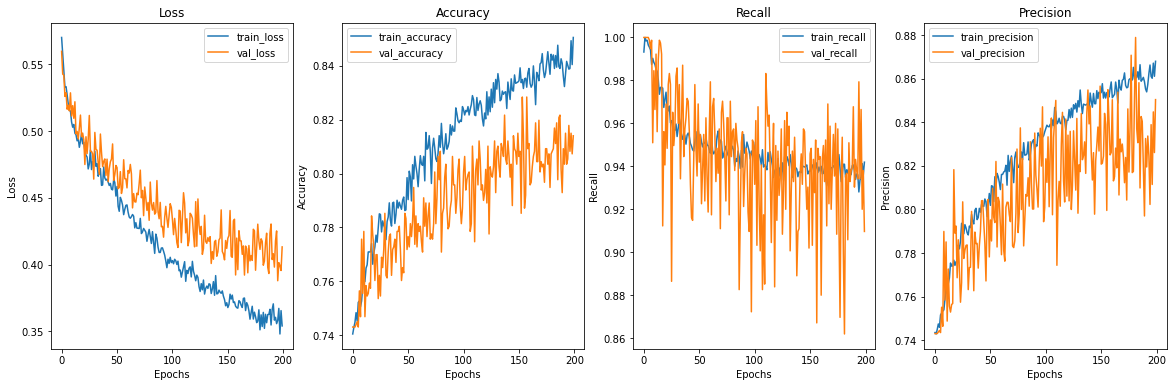

In [56]:
model_metrics(fsm_aug_results)

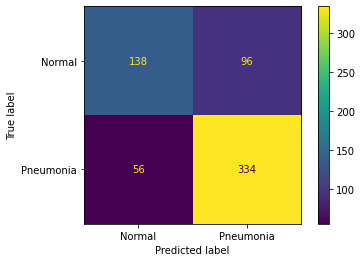

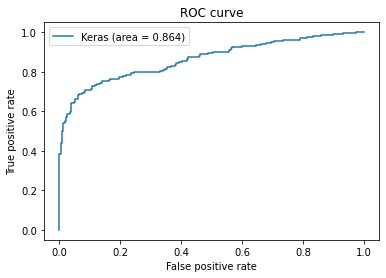

In [59]:
conf_and_rocauc(fsm_aug)

### multilayer model

After deducing that augmented data provides more robust model training, we chose to add complexity to the model. We will train on augmented data from here forward.

Adding additional hidden layers can result in overfitting. Therefore, we added L2 regularization to our hidden layers, and switched the activation function of the hidden layers [from sigmoid to relu](https://machinelearningmastery.com/activation-regularization-for-reducing-generalization-error-in-deep-learning-neural-networks/). 

In [53]:
multilayer_model = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

multilayer_model.compile(optimizer='SGD',
                         loss='binary_crossentropy',
                         metrics=['accuracy', 'Recall', 'Precision', 
                                  'TruePositives', 'TrueNegatives', 
                                  'FalsePositives', 'FalseNegatives', 
                                  'AUC'])

In [54]:
multilayer_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                524320    
_________________________________________________________________
dense_19 (Dense)             (None, 12)                396       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 524,829
Trainable params: 524,829
Non-trainable params: 0
_________________________________________________________________


In [55]:
multilayer_model_results = multilayer_model.fit(train_set_aug, 
                                                epochs=200,
                                                batch_size=None, 
                                                verbose=1, 
                                                validation_data=validation_set_aug)

Epoch 1/200
131/131 [==============================] - 46s 355ms/step - loss: 0.6648 - accuracy: 0.7381 - recall: 0.9923 - precision: 0.7421 - true_positives: 3076.0000 - true_negatives: 4.0000 - false_positives: 1069.0000 - false_negatives: 24.0000 - auc: 0.5348 - val_loss: 0.6614 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.6478
Epoch 2/200
131/131 [==============================] - 44s 337ms/step - loss: 0.6520 - accuracy: 0.7431 - recall: 1.0000 - precision: 0.7430 - true_positives: 3100.0000 - true_negatives: 1.0000 - false_positives: 1072.0000 - false_negatives: 0.0000e+00 - auc: 0.5798 - val_loss: 0.6350 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.7038

Epoch 34/200
131/131 [==============================] - 47s 359ms/step - loss: 0.5168 - accuracy: 0.8021 - recall: 0.9042 - precision: 0.8412 - true_positives: 2803.0000 - true_negatives: 544.0000 - false_positives: 529.0000 - false_negatives: 297.0000 - auc: 0.8235 - val_loss: 0.5313 - val_accuracy: 0.7785 - val_recall: 0.9058 - val_precision: 0.8163 - val_true_positives: 702.0000 - val_true_negatives: 110.0000 - val_false_positives: 158.0000 - val_false_negatives: 73.0000 - val_auc: 0.8062
Epoch 35/200
131/131 [==============================] - 47s 360ms/step - loss: 0.5088 - accuracy: 0.8126 - recall: 0.9219 - precision: 0.8411 - true_positives: 2858.0000 - true_negatives: 533.0000 - false_positives: 540.0000 - false_negatives: 242.0000 - auc: 0.8302 - val_loss: 0.5526 - val_accuracy: 0.7900 - val_recall: 0.9561 - val_precision: 0.8002 - val_true_positives: 741.0000 - val_true_negatives: 83.0000 - val_false_positives: 185.0000 - val_false_negatives: 34.0000 - val_auc: 0.7965
Epoch 3

131/131 [==============================] - 47s 357ms/step - loss: 0.4745 - accuracy: 0.8179 - recall: 0.9119 - precision: 0.8530 - true_positives: 2827.0000 - true_negatives: 586.0000 - false_positives: 487.0000 - false_negatives: 273.0000 - auc: 0.8541 - val_loss: 0.5047 - val_accuracy: 0.7891 - val_recall: 0.8968 - val_precision: 0.8323 - val_true_positives: 695.0000 - val_true_negatives: 128.0000 - val_false_positives: 140.0000 - val_false_negatives: 80.0000 - val_auc: 0.8266
Epoch 67/200
131/131 [==============================] - 47s 358ms/step - loss: 0.4667 - accuracy: 0.8234 - recall: 0.9168 - precision: 0.8558 - true_positives: 2842.0000 - true_negatives: 594.0000 - false_positives: 479.0000 - false_negatives: 258.0000 - auc: 0.8614 - val_loss: 0.5263 - val_accuracy: 0.7766 - val_recall: 0.9303 - val_precision: 0.8011 - val_true_positives: 721.0000 - val_true_negatives: 89.0000 - val_false_positives: 179.0000 - val_false_negatives: 54.0000 - val_auc: 0.8244
Epoch 68/200
131/131

131/131 [==============================] - 47s 357ms/step - loss: 0.4448 - accuracy: 0.8289 - recall: 0.9177 - precision: 0.8611 - true_positives: 2845.0000 - true_negatives: 614.0000 - false_positives: 459.0000 - false_negatives: 255.0000 - auc: 0.8740 - val_loss: 0.4804 - val_accuracy: 0.7948 - val_recall: 0.9161 - val_precision: 0.8265 - val_true_positives: 710.0000 - val_true_negatives: 119.0000 - val_false_positives: 149.0000 - val_false_negatives: 65.0000 - val_auc: 0.8469
Epoch 99/200
131/131 [==============================] - 47s 357ms/step - loss: 0.4494 - accuracy: 0.8299 - recall: 0.9090 - precision: 0.8681 - true_positives: 2818.0000 - true_negatives: 645.0000 - false_positives: 428.0000 - false_negatives: 282.0000 - auc: 0.8701 - val_loss: 0.4901 - val_accuracy: 0.7996 - val_recall: 0.9497 - val_precision: 0.8124 - val_true_positives: 736.0000 - val_true_negatives: 98.0000 - val_false_positives: 170.0000 - val_false_negatives: 39.0000 - val_auc: 0.8567
Epoch 100/200
131/13

131/131 [==============================] - 47s 358ms/step - loss: 0.4156 - accuracy: 0.8478 - recall: 0.9271 - precision: 0.8754 - true_positives: 2874.0000 - true_negatives: 664.0000 - false_positives: 409.0000 - false_negatives: 226.0000 - auc: 0.8904 - val_loss: 0.4884 - val_accuracy: 0.7910 - val_recall: 0.8774 - val_precision: 0.8468 - val_true_positives: 680.0000 - val_true_negatives: 145.0000 - val_false_positives: 123.0000 - val_false_negatives: 95.0000 - val_auc: 0.8380
Epoch 131/200
131/131 [==============================] - 47s 359ms/step - loss: 0.4353 - accuracy: 0.8260 - recall: 0.9052 - precision: 0.8666 - true_positives: 2806.0000 - true_negatives: 641.0000 - false_positives: 432.0000 - false_negatives: 294.0000 - auc: 0.8760 - val_loss: 0.4858 - val_accuracy: 0.7891 - val_recall: 0.8929 - val_precision: 0.8347 - val_true_positives: 692.0000 - val_true_negatives: 131.0000 - val_false_positives: 137.0000 - val_false_negatives: 83.0000 - val_auc: 0.8358
Epoch 132/200
131/

131/131 [==============================] - 48s 363ms/step - loss: 0.4128 - accuracy: 0.8375 - recall: 0.9129 - precision: 0.8740 - true_positives: 2830.0000 - true_negatives: 665.0000 - false_positives: 408.0000 - false_negatives: 270.0000 - auc: 0.8898 - val_loss: 0.4565 - val_accuracy: 0.8044 - val_recall: 0.8916 - val_precision: 0.8520 - val_true_positives: 691.0000 - val_true_negatives: 148.0000 - val_false_positives: 120.0000 - val_false_negatives: 84.0000 - val_auc: 0.8579
Epoch 163/200
131/131 [==============================] - 47s 362ms/step - loss: 0.4077 - accuracy: 0.8493 - recall: 0.9235 - precision: 0.8796 - true_positives: 2863.0000 - true_negatives: 681.0000 - false_positives: 392.0000 - false_negatives: 237.0000 - auc: 0.8918 - val_loss: 0.4620 - val_accuracy: 0.7996 - val_recall: 0.9316 - val_precision: 0.8223 - val_true_positives: 722.0000 - val_true_negatives: 112.0000 - val_false_positives: 156.0000 - val_false_negatives: 53.0000 - val_auc: 0.8690
Epoch 164/200
131/

131/131 [==============================] - 47s 361ms/step - loss: 0.3939 - accuracy: 0.8399 - recall: 0.9132 - precision: 0.8765 - true_positives: 2831.0000 - true_negatives: 674.0000 - false_positives: 399.0000 - false_negatives: 269.0000 - auc: 0.9002 - val_loss: 0.4691 - val_accuracy: 0.8035 - val_recall: 0.9394 - val_precision: 0.8217 - val_true_positives: 728.0000 - val_true_negatives: 110.0000 - val_false_positives: 158.0000 - val_false_negatives: 47.0000 - val_auc: 0.8523
Epoch 195/200
131/131 [==============================] - 47s 361ms/step - loss: 0.4092 - accuracy: 0.8435 - recall: 0.9184 - precision: 0.8768 - true_positives: 2847.0000 - true_negatives: 673.0000 - false_positives: 400.0000 - false_negatives: 253.0000 - auc: 0.8865 - val_loss: 0.4416 - val_accuracy: 0.8207 - val_recall: 0.9148 - val_precision: 0.8542 - val_true_positives: 709.0000 - val_true_negatives: 147.0000 - val_false_positives: 121.0000 - val_false_negatives: 66.0000 - val_auc: 0.8647
Epoch 196/200
131/

In [132]:
# output_path = root_path + 'data/multilayer_model.h5'
# multilayer_model.save(output_path)

# # Appears that you also need to save history separately
# # convert results.history to csv and save it out
# hist_df = pd.DataFrame(multilayer_model_results.history)
# hist_df.to_csv(output_path.replace(".h5", ".csv"), index=False)

AUC score (train final epoch): 0.889
AUC score (val final epoch)  : 0.841


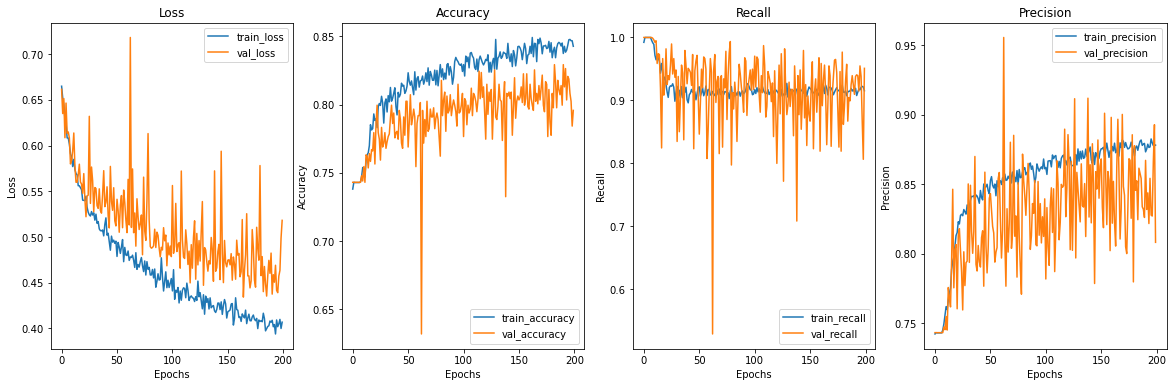

In [60]:
model_metrics(multilayer_model_results)

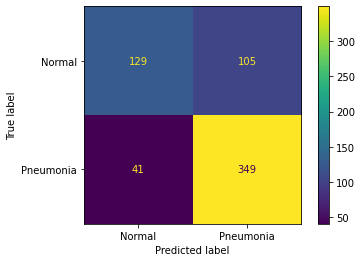

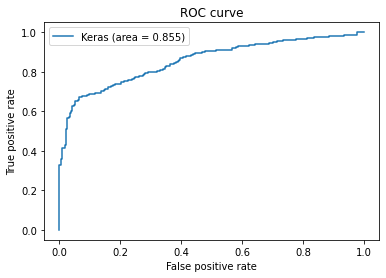

In [61]:
conf_and_rocauc(multilayer_model)

### CNN

In [62]:
deep_cnn = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

deep_cnn.compile(optimizer='SGD',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'Recall', 'Precision', 
                          'TruePositives', 'TrueNegatives', 
                          'FalsePositives', 'FalseNegatives', 
                          'AUC'])

deep_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 57600)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1843232   
_________________________________________________________________
dense_23 (Dense)             (None, 12)              

In [63]:
deep_cnn_results = deep_cnn.fit(train_set_aug, 
                                epochs=200, 
                                batch_size=None, 
                                validation_data=validation_set_aug)

Epoch 1/200
131/131 [==============================] - 83s 632ms/step - loss: 0.6680 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.5040 - val_loss: 0.6598 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.6011
Epoch 2/200
131/131 [==============================] - 79s 604ms/step - loss: 0.6594 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.5340 - val_loss: 0.6487 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_

131/131 [==============================] - 78s 598ms/step - loss: 0.3898 - accuracy: 0.8622 - recall: 0.9235 - precision: 0.8944 - true_positives: 2863.0000 - true_negatives: 735.0000 - false_positives: 338.0000 - false_negatives: 237.0000 - auc: 0.9217 - val_loss: 0.4510 - val_accuracy: 0.8322 - val_recall: 0.9677 - val_precision: 0.8333 - val_true_positives: 750.0000 - val_true_negatives: 118.0000 - val_false_positives: 150.0000 - val_false_negatives: 25.0000 - val_auc: 0.8987
Epoch 34/200
131/131 [==============================] - 78s 594ms/step - loss: 0.3900 - accuracy: 0.8677 - recall: 0.9281 - precision: 0.8974 - true_positives: 2877.0000 - true_negatives: 744.0000 - false_positives: 329.0000 - false_negatives: 223.0000 - auc: 0.9197 - val_loss: 0.4664 - val_accuracy: 0.8332 - val_recall: 0.9510 - val_precision: 0.8442 - val_true_positives: 737.0000 - val_true_negatives: 132.0000 - val_false_positives: 136.0000 - val_false_negatives: 38.0000 - val_auc: 0.8723
Epoch 35/200
131/13

Epoch 50/200
131/131 [==============================] - 78s 595ms/step - loss: 0.3217 - accuracy: 0.9006 - recall: 0.9439 - precision: 0.9239 - true_positives: 2926.0000 - true_negatives: 832.0000 - false_positives: 241.0000 - false_negatives: 174.0000 - auc: 0.9510 - val_loss: 0.3689 - val_accuracy: 0.8610 - val_recall: 0.8994 - val_precision: 0.9123 - val_true_positives: 697.0000 - val_true_negatives: 201.0000 - val_false_positives: 67.0000 - val_false_negatives: 78.0000 - val_auc: 0.9322
Epoch 51/200
131/131 [==============================] - 78s 595ms/step - loss: 0.3267 - accuracy: 0.8967 - recall: 0.9406 - precision: 0.9219 - true_positives: 2916.0000 - true_negatives: 826.0000 - false_positives: 247.0000 - false_negatives: 184.0000 - auc: 0.9485 - val_loss: 0.3856 - val_accuracy: 0.8504 - val_recall: 0.9368 - val_precision: 0.8715 - val_true_positives: 726.0000 - val_true_negatives: 161.0000 - val_false_positives: 107.0000 - val_false_negatives: 49.0000 - val_auc: 0.9249
Epoch 5

Epoch 83/200
131/131 [==============================] - 78s 593ms/step - loss: 0.2671 - accuracy: 0.9178 - recall: 0.9494 - precision: 0.9406 - true_positives: 2943.0000 - true_negatives: 887.0000 - false_positives: 186.0000 - false_negatives: 157.0000 - auc: 0.9689 - val_loss: 0.3192 - val_accuracy: 0.8811 - val_recall: 0.9097 - val_precision: 0.9289 - val_true_positives: 705.0000 - val_true_negatives: 214.0000 - val_false_positives: 54.0000 - val_false_negatives: 70.0000 - val_auc: 0.9510
Epoch 84/200
131/131 [==============================] - 78s 594ms/step - loss: 0.2705 - accuracy: 0.9171 - recall: 0.9487 - precision: 0.9402 - true_positives: 2941.0000 - true_negatives: 886.0000 - false_positives: 187.0000 - false_negatives: 159.0000 - auc: 0.9673 - val_loss: 0.3016 - val_accuracy: 0.8945 - val_recall: 0.9458 - val_precision: 0.9151 - val_true_positives: 733.0000 - val_true_negatives: 200.0000 - val_false_positives: 68.0000 - val_false_negatives: 42.0000 - val_auc: 0.9589
Epoch 85

131/131 [==============================] - 78s 595ms/step - loss: 0.2536 - accuracy: 0.9224 - recall: 0.9513 - precision: 0.9446 - true_positives: 2949.0000 - true_negatives: 900.0000 - false_positives: 173.0000 - false_negatives: 151.0000 - auc: 0.9701 - val_loss: 0.2492 - val_accuracy: 0.9185 - val_recall: 0.9561 - val_precision: 0.9356 - val_true_positives: 741.0000 - val_true_negatives: 217.0000 - val_false_positives: 51.0000 - val_false_negatives: 34.0000 - val_auc: 0.9734
Epoch 116/200
131/131 [==============================] - 78s 594ms/step - loss: 0.2489 - accuracy: 0.9233 - recall: 0.9484 - precision: 0.9484 - true_positives: 2940.0000 - true_negatives: 913.0000 - false_positives: 160.0000 - false_negatives: 160.0000 - auc: 0.9710 - val_loss: 0.2929 - val_accuracy: 0.8965 - val_recall: 0.9639 - val_precision: 0.9033 - val_true_positives: 747.0000 - val_true_negatives: 188.0000 - val_false_positives: 80.0000 - val_false_negatives: 28.0000 - val_auc: 0.9649
Epoch 117/200
131/13

131/131 [==============================] - 79s 600ms/step - loss: 0.2326 - accuracy: 0.9307 - recall: 0.9565 - precision: 0.9506 - true_positives: 2965.0000 - true_negatives: 919.0000 - false_positives: 154.0000 - false_negatives: 135.0000 - auc: 0.9746 - val_loss: 0.2589 - val_accuracy: 0.9080 - val_recall: 0.9174 - val_precision: 0.9569 - val_true_positives: 711.0000 - val_true_negatives: 236.0000 - val_false_positives: 32.0000 - val_false_negatives: 64.0000 - val_auc: 0.9690
Epoch 148/200
131/131 [==============================] - 77s 589ms/step - loss: 0.2360 - accuracy: 0.9279 - recall: 0.9542 - precision: 0.9490 - true_positives: 2958.0000 - true_negatives: 914.0000 - false_positives: 159.0000 - false_negatives: 142.0000 - auc: 0.9739 - val_loss: 0.2648 - val_accuracy: 0.9108 - val_recall: 0.9187 - val_precision: 0.9596 - val_true_positives: 712.0000 - val_true_negatives: 238.0000 - val_false_positives: 30.0000 - val_false_negatives: 63.0000 - val_auc: 0.9693
Epoch 149/200
131/13

131/131 [==============================] - 75s 573ms/step - loss: 0.2180 - accuracy: 0.9372 - recall: 0.9577 - precision: 0.9577 - true_positives: 2969.0000 - true_negatives: 942.0000 - false_positives: 131.0000 - false_negatives: 131.0000 - auc: 0.9769 - val_loss: 0.2455 - val_accuracy: 0.9214 - val_recall: 0.9303 - val_precision: 0.9626 - val_true_positives: 721.0000 - val_true_negatives: 240.0000 - val_false_positives: 28.0000 - val_false_negatives: 54.0000 - val_auc: 0.9730
Epoch 180/200
131/131 [==============================] - 75s 570ms/step - loss: 0.2179 - accuracy: 0.9346 - recall: 0.9590 - precision: 0.9532 - true_positives: 2973.0000 - true_negatives: 927.0000 - false_positives: 146.0000 - false_negatives: 127.0000 - auc: 0.9765 - val_loss: 0.2371 - val_accuracy: 0.9118 - val_recall: 0.9484 - val_precision: 0.9339 - val_true_positives: 735.0000 - val_true_negatives: 216.0000 - val_false_positives: 52.0000 - val_false_negatives: 40.0000 - val_auc: 0.9729
Epoch 181/200
131/13

In [133]:
# output_path = root_path + 'data/deep_cnn.h5'
# deep_cnn.save(output_path)

# # Appears that you also need to save history separately
# # convert results.history to csv and save it out
# hist_df = pd.DataFrame(deep_cnn_results.history)
# hist_df.to_csv(output_path.replace(".h5", ".csv"), index=False)

AUC score (train final epoch): 0.980
AUC score (val final epoch)  : 0.974


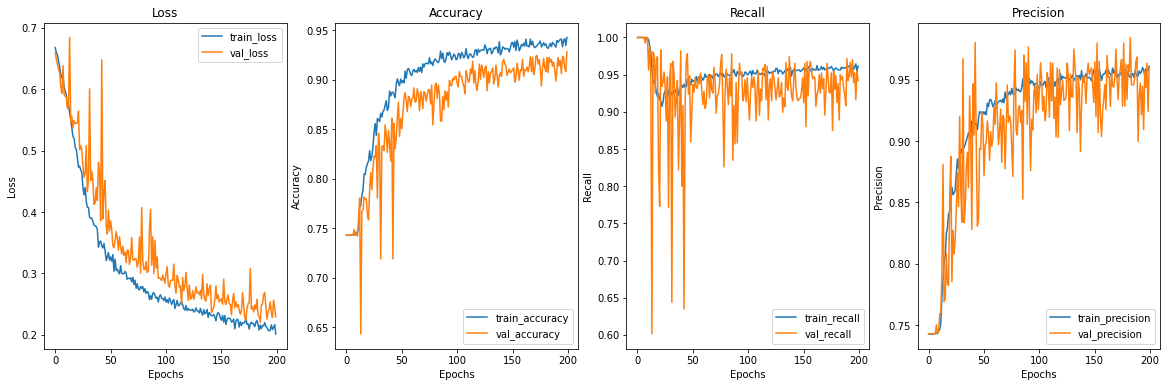

In [64]:
model_metrics(deep_cnn_results)

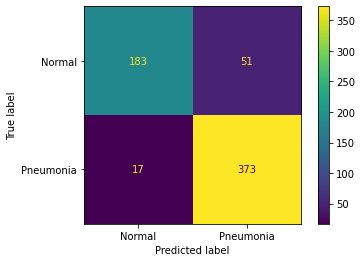

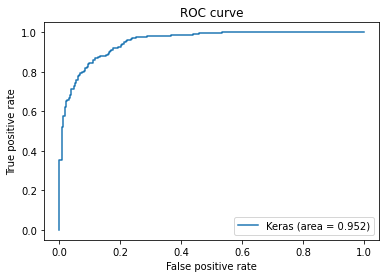

In [65]:
conf_and_rocauc(deep_cnn)

### Updated CNN model with dropout layers

We ran this model in a separate notebook, saved the model as a .h5 file using the mode.save() method, and saved the results.history as a .csv file using Pandas. To use that model and plot the training performance in this notebook, we need to read in the .h5 and .csv files that were saved in the `data/` directory.

In [19]:
deep_cnn_updated = models.load_model('data/deep_cnn_updated_v2.h5')

In [9]:
deep_cnn_updated_history = pd.read_csv('data/deep_cnn_updated_v2.csv')

This is the function used to setup and compile the model. It is commented it out, since we just loaded in the model above.

In [ ]:
# deep_cnn_updated = models.Sequential([
#     layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dropout(0.25),
#     layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(1, activation='sigmoid')
# ])

# deep_cnn_updated.compile(optimizer='SGD',
#                  loss='binary_crossentropy',
#                  metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])

This is the call to the models .fit() method. It is commented it out, since we load the model and results.history below.

It could take 6-8 hours to run (using multithreaded processes on CPU). 

In [ ]:
# deep_cnn_updated_results = deep_cnn_updated.fit(train_set_aug, 
#                                                 epochs=200, 
#                                                 batch_size=None, 
#                                                 validation_data=validation_set_aug)

In [20]:
deep_cnn_updated.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 57600)            

We can view the full model training performance history using the pandas df read in from csv

In [122]:
deep_cnn_updated_history

,loss,accuracy,recall,precision,true_positives,true_negatives,false_positives,false_negatives,auc,val_loss,val_accuracy,val_recall,val_precision,val_true_positives,val_true_negatives,val_false_positives,val_false_negatives,val_auc
0,0.681604,0.735921,0.985806,0.742829,3056.0,15.0,1058.0,44.0,0.506011,0.671009,0.743049,1.000000,0.743049,775.0,0.0,268.0,0.0,0.592198
1,0.669842,0.742871,1.000000,0.742871,3100.0,0.0,1073.0,0.0,0.506467,0.659723,0.743049,1.000000,0.743049,775.0,0.0,268.0,0.0,0.600416
2,0.667937,0.742871,1.000000,0.742871,3100.0,0.0,1073.0,0.0,0.504959,0.664761,0.743049,1.000000,0.743049,775.0,0.0,268.0,0.0,0.624487
3,0.658316,0.742871,1.000000,0.742871,3100.0,0.0,1073.0,0.0,0.542206,0.658422,0.743049,1.000000,0.743049,775.0,0.0,268.0,0.0,0.653522
4,0.658956,0.742871,1.000000,0.742871,3100.0,0.0,1073.0,0.0,0.542474,0.653762,0.743049,1.000000,0.743049,775.0,0.0,268.0,0.0,0.637338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.250941,0.922358,0.950645,0.945157,2947.0,902.0,171.0,153.0,0.965992,0.330294,0.878236,0.868387,0.964183,673.0,243.0,25.0,102.0,0.954434
196,0.244994,0.925713,0.953548,0.946829,2956.0,907.0,166.0,144.0,0.968228,0.275749,0.905082,0.922581,0.948276,715.0,229.0,39.0,60.0,0.964273
197,0.247139,0.922598,0.953871,0.942620,2957.0,893.0,180.0,143.0,0.967779,0.280388,0.894535,0.953548,0.908979,739.0,194.0,74.0,36.0,0.959726
198,0.245783,0.923317,0.952903,0.944373,2954.0,899.0,174.0,146.0,0.967878,0.271334,0.900288,0.944516,0.923077,732.0,207.0,61.0,43.0,0.962537


We need to plot the training performance from the pandas dataframe, because the history is no longer in a keras callbacks history object.

AUC score (train final epoch): 0.967
AUC score (val final epoch)  : 0.971


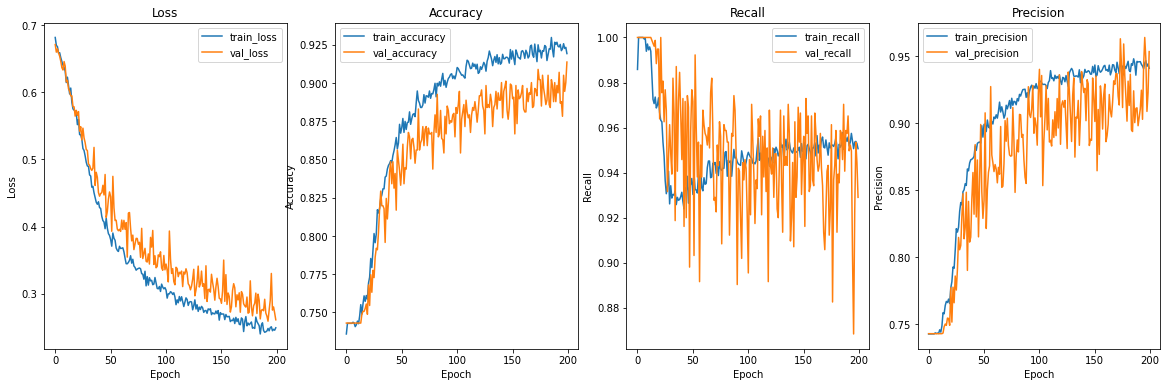

In [18]:
model_metrics_from_dataframe(deep_cnn_updated_history)

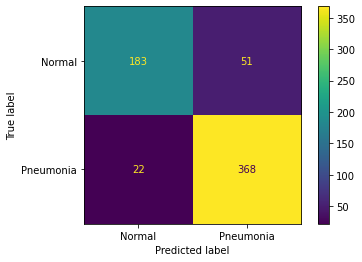

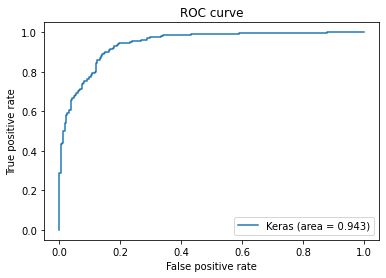

In [21]:
conf_and_rocauc(deep_cnn_updated)

In [120]:
deep_cnn_updated.evaluate(test_set)

20/20 [==============================] - 5s 245ms/step - loss: 0.3545 - accuracy: 0.8830 - recall_1: 0.9436 - precision_1: 0.8783 - true_positives_1: 368.0000 - true_negatives_1: 183.0000 - false_positives_1: 51.0000 - false_negatives_1: 22.0000 - auc_1: 0.9428


[0.35452237725257874,
 0.8830128312110901,
 0.9435897469520569,
 0.8782815933227539,
 368.0,
 183.0,
 51.0,
 22.0,
 0.9428062438964844]

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Evaluation

#### Precision and Recall as primary metrics for model evaluation

We needed to choose our metrics for evaluating model accuracy carefully.  While we still reviewed other metrics to get a complete picture of our model performance, we focused more strongly on **precision** and **recall** for several reasons.

- **Recall**: First, we want our neural network to correctly identify true positive cases of pneumonia as often as possible. This is measured using a metric called “recall”, which is sometimes called "sensitivity" in the medical literature.
    
- **Precision**: We don't want to maximize our recall/sensitivity at the cost of classifying *healthy* children as having pneumonia. We want to avoid mislabeling children who are negative for pneumonia, in order to preserve valuable medical resources for those children who most need them. To do this, we maximized a metric called “precision”, which measures, of all of the cases that are labelled positive by the model, what proportion were true positives. Maximizing the proportion of true positives in the cases that are labelled as pneumonia by our model will in turn minimize the number of false negative cases that might receive improper treatment due to our model.



The `deep_cnn_updated` model seems to perform ever so slightly worse than the prior `deep_cnn` model. 

Specifically, for the `deep_cnn` model without dropout layers, the ROC-AUC on the validation set was slightly higher, as were the accuracy, recall, and precision on the withheld test set compared to the `deep_cnn_updated` model with dropout layers. 

Therefore, the `deep_cnn` model should be preferred as our final model.

We opted to use the original `deep_cnn` model with convolution and multiple hidden layers including a small amount of l2 regularization.

In [66]:
deep_cnn_test = deep_cnn.evaluate(test_set)

20/20 [==============================] - 4s 204ms/step - loss: 0.3450 - accuracy: 0.8910 - recall: 0.9564 - precision: 0.8797 - true_positives: 373.0000 - true_negatives: 183.0000 - false_positives: 51.0000 - false_negatives: 17.0000 - auc: 0.9510


In [67]:
##cnn5_loss, cnn5_acc, cnn5_recall, cnn5_prc = cnn5_model.evaluate(test_set)
deep_cnn_acc = deep_cnn_test[1]
deep_cnn_recall = deep_cnn_test[2]
deep_cnn_precision = deep_cnn_test[3]

In [78]:
print(base_acc, deep_cnn_acc)

0.625 0.8910256624221802


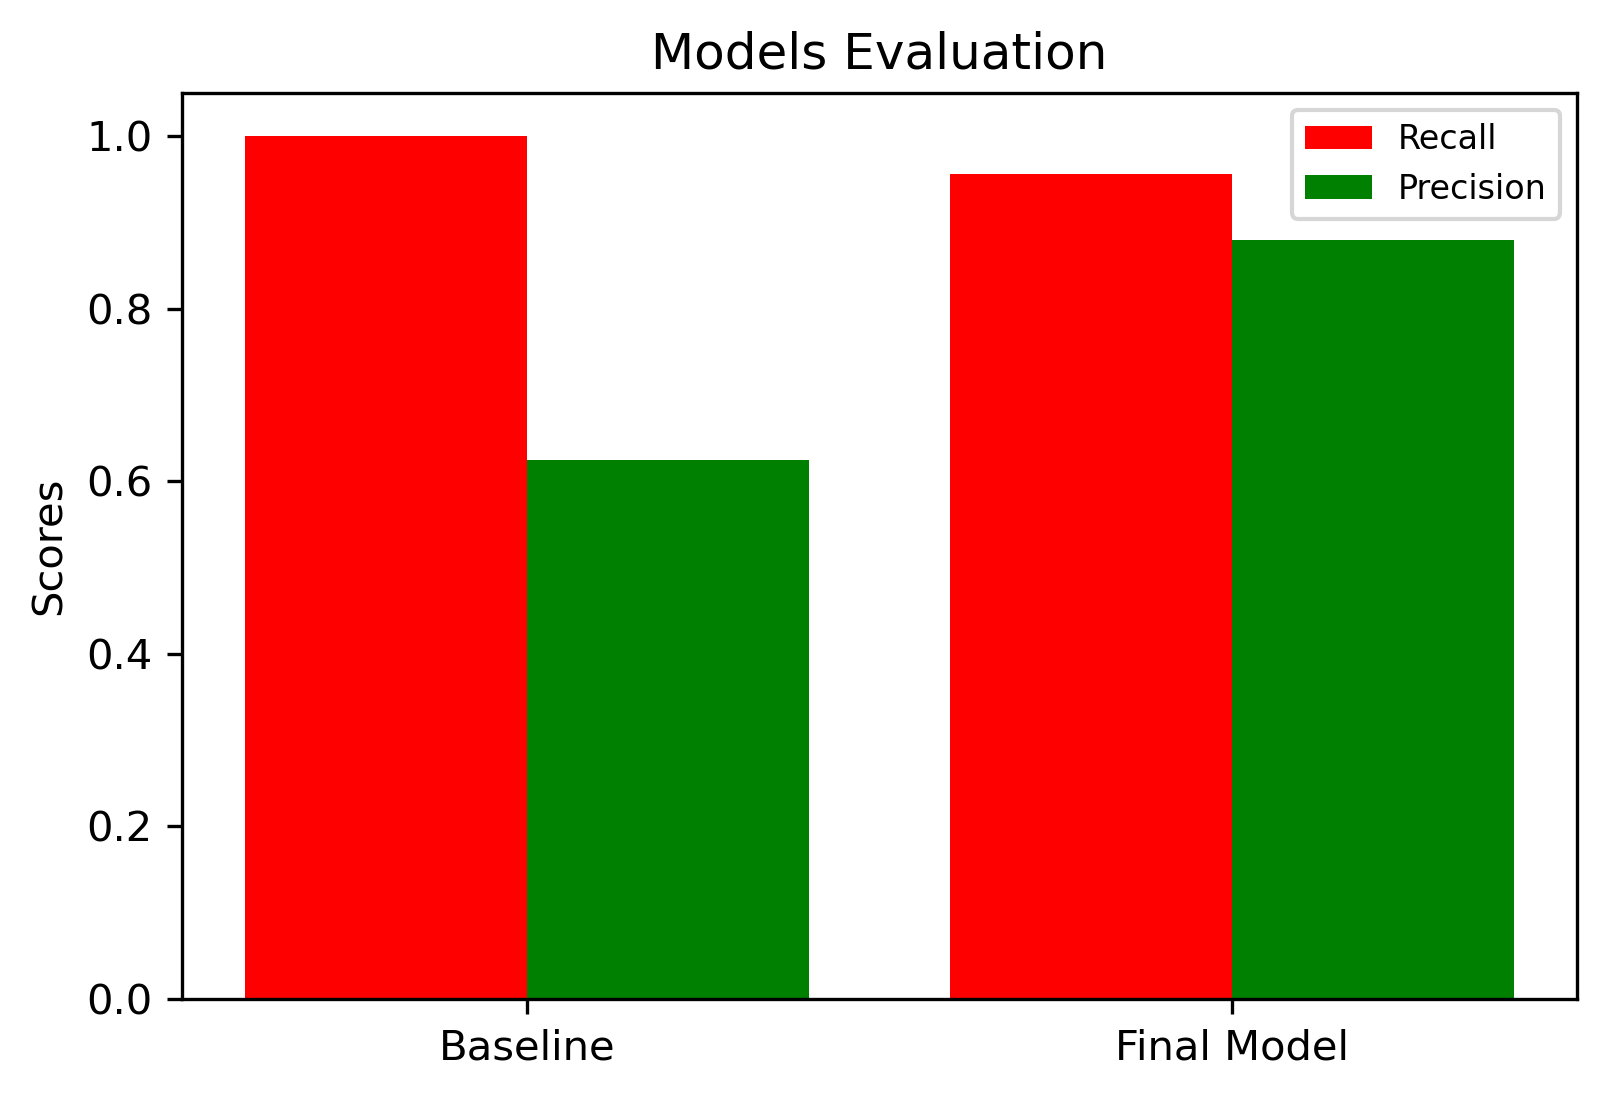

In [82]:
x = np.arange(2)
acc_scores = [base_recall, deep_cnn_recall]
prec_scores = [base_precision, deep_cnn_precision]
width = 0.4

fig, ax = plt.subplots(dpi=300)
plt.bar(x - 0.2, acc_scores, width, color='r')
plt.bar(x + 0.2, prec_scores, width, color='g')
plt.xticks(x, ['Baseline', 'Final Model'])
plt.ylabel('Scores')
plt.title('Models Evaluation')
ax.legend(['Recall', 'Precision'], fontsize=8);
#plt.savefig('images/model_comparisons.jpg', transparent = False, bbox_inches="tight");

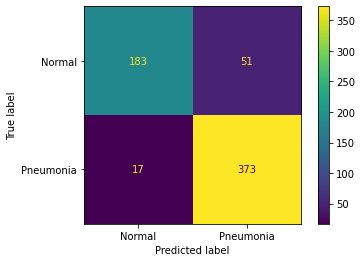

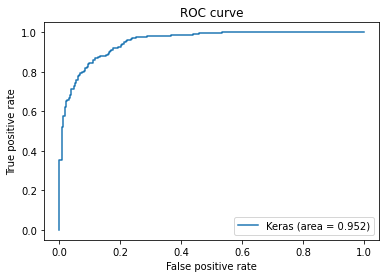

In [90]:
conf_and_rocauc(deep_cnn)

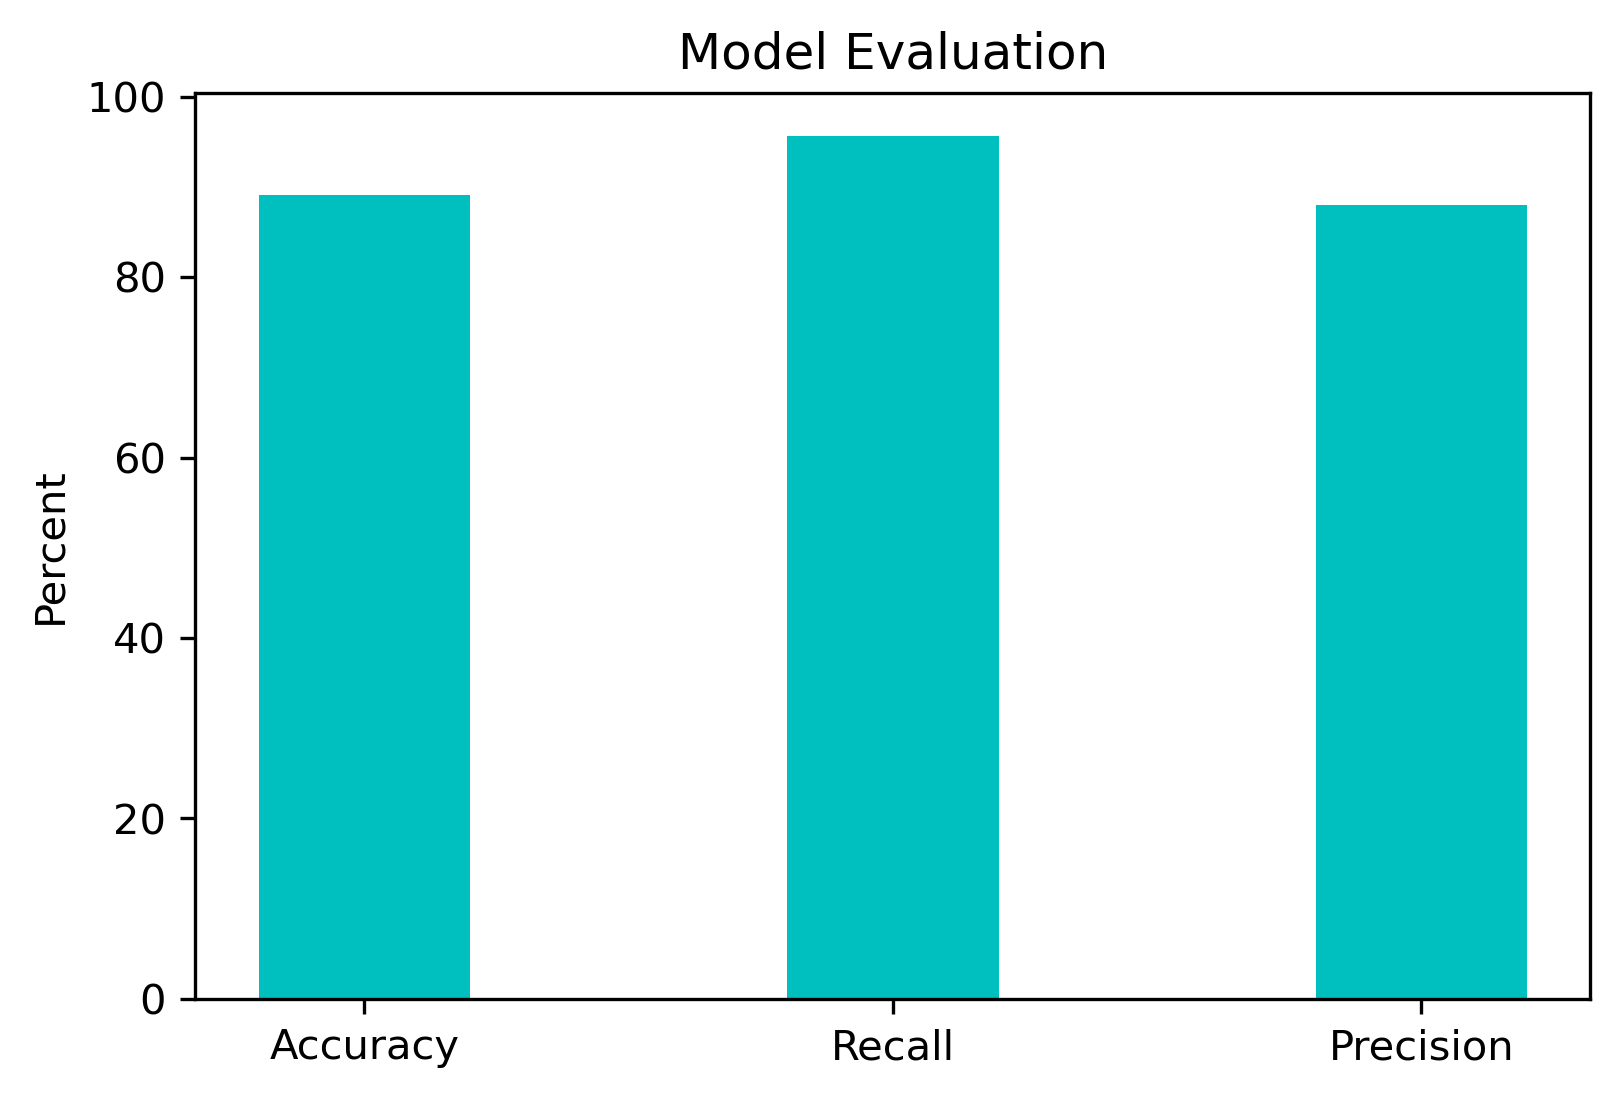

In [115]:
x = np.arange(3)
scores = [deep_cnn_acc*100, deep_cnn_recall*100, deep_cnn_precision*100]
width = 0.4

fig, ax = plt.subplots(dpi=300)
plt.bar(x, scores, width, color='c')
plt.xticks(x, ['Accuracy', 'Recall', 'Precision'])
plt.ylabel('Percent')
plt.title('Model Evaluation');
plt.savefig('images/model_evaluation_trans.png', transparent = True, bbox_inches="tight");

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***